In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [3]:
# read data
train = pd.read_csv('input-rss/train.csv')
store = pd.read_csv('input-rss/store.csv')
test = pd.read_csv('input-rss/test.csv')

/var/folders/_y/hzd68ny17rsfgx2sq7wtmxcw0000gn/T/ipykernel_11378/309179011.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input-rss/train.csv')


In [4]:
print(store.info()) 
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dty

### Store
- CompetitionDistance (3 null) mit durchschnitt eintragen
- CompetitionOpenSinceMonth -> gelöscht, da ≥ 50% nan
- CompetitionOpenSinceYear -> gelöscht da ≥ 50% nan
- Promo2 -> 0: kein Promo2, 
            1: Promo2 aktiv -> Promo2SinceWeek, Promo2SinceYear, PromoInterval

### Train
- Date -> Datum; Änderung in Datetime bzw. Jahr, Monat, Tag, Woche, Tag im Jahr, Tag der Woche, Feiertag
- StateHoliday -> 0: kein Feiertag, a: Feiertag (Gesetzlich), b: Feiertag (Ostern), c: Feiertag (Christmas); Änderung in 0, 1, 2, 3
- SchoolHoliday -> 0: kein Schulferien, 1: Schulferien

In [5]:
# data cleaning
# fill missing CompetitionDistance with mean
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [6]:
# drop columns 4 and 5 of store
store.drop(store.columns[[4,5]], axis=1, inplace=True)

In [7]:
# map strings to categorical values
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2})
store.head()


,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,NaN,NaN,NaN
1,2,0,0,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,0,0,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,2,2,620.0,0,NaN,NaN,NaN
4,5,0,0,29910.0,0,NaN,NaN,NaN


In [8]:
# encode PromoInterval
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
store['PromoInterval'] = le.fit_transform(store['PromoInterval'].astype(str))
store['Promo2SinceWeek'] = le.fit_transform(store['Promo2SinceWeek'].astype(str))
store['Promo2SinceYear'] = le.fit_transform(store['Promo2SinceYear'].astype(str))

In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,24,7,3
1,2,0,0,570.0,1,2,1,1
2,3,0,0,14130.0,1,3,2,1
3,4,2,2,620.0,0,24,7,3
4,5,0,0,29910.0,0,24,7,3


# Data Cleaning Train & Test Data

In [10]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [11]:
train['StateHoliday'] = le.fit_transform(train['StateHoliday'].astype(str))
print(train.head())

test['StateHoliday'] = le.fit_transform(test['StateHoliday'].astype(str))
test['Open'] = le.fit_transform(test['Open'].astype(str))
print(test.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      2          5  2015-07-31   6064        625     1      1             0   
2      3          5  2015-07-31   8314        821     1      1             0   
3      4          5  2015-07-31  13995       1498     1      1             0   
4      5          5  2015-07-31   4822        559     1      1             0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo  StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17     1      1             0              0
1   2      3          4  2015-09-17     1      1             0              0
2   3      7          4  2015-09-17     1      1             0              0
3   4      8          4  2015-09-17     1      1             0              0
4   5      9   

Date bei beiden Datensätzen in Jahr, Monat, Tag aufteilen.

In [12]:
# split date into year, month, day
train['Date'] = pd.to_datetime(train['Date'])
train['Date_Year'] = train['Date'].dt.year
train['Date_Month'] = train['Date'].dt.month
train['Date_Day'] = train['Date'].dt.day
train = train.drop('Date', axis=1)

# split date into year, month, day
test['Date'] = pd.to_datetime(test['Date'])
test['Date_Year'] = test['Date'].dt.year
test['Date_Month'] = test['Date'].dt.month
test['Date_Day'] = test['Date'].dt.day
test = test.drop('Date', axis=1)


In [13]:
print(train.head())
print(test.head())

   Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5   5263        555     1      1             0   
1      2          5   6064        625     1      1             0   
2      3          5   8314        821     1      1             0   
3      4          5  13995       1498     1      1             0   
4      5          5   4822        559     1      1             0   

   SchoolHoliday  Date_Year  Date_Month  Date_Day  
0              1       2015           7        31  
1              1       2015           7        31  
2              1       2015           7        31  
3              1       2015           7        31  
4              1       2015           7        31  
   Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Date_Year  \
0   1      1          4     1      1             0              0       2015   
1   2      3          4     1      1             0              0       2015   
2   3      7          4     1      1   

for later use
```# merge year, month, day to date
train['Date'] = train['Date_Year'].map(str) + '-' + train['Date_Month'].map(str) + '-' + train['Date_Day'].map(str)```

In [14]:
# merge train and store assortments
train = pd.merge(train, 
                 store[['StoreType', 'Assortment']],
                 left_on='Store', 
                 right_index=True)
test = pd.merge(test, 
                store[['StoreType', 'Assortment']],
                left_on='Store', 
                right_index=True)

print(train.head())
print(test.head())

      Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0         1          5   5263        555     1      1             0   
1115      1          4   5020        546     1      1             0   
2230      1          3   4782        523     1      1             0   
3345      1          2   5011        560     1      1             0   
4460      1          1   6102        612     1      1             0   

      SchoolHoliday  Date_Year  Date_Month  Date_Day  StoreType  Assortment  
0                 1       2015           7        31          0           0  
1115              1       2015           7        30          0           0  
2230              1       2015           7        29          0           0  
3345              1       2015           7        28          0           0  
4460              1       2015           7        27          0           0  
        Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  \
0        1      1          4   

In [15]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017207
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   Store          1016267 non-null  int64
 1   DayOfWeek      1016267 non-null  int64
 2   Sales          1016267 non-null  int64
 3   Customers      1016267 non-null  int64
 4   Open           1016267 non-null  int64
 5   Promo          1016267 non-null  int64
 6   StateHoliday   1016267 non-null  int64
 7   SchoolHoliday  1016267 non-null  int64
 8   Date_Year      1016267 non-null  int64
 9   Date_Month     1016267 non-null  int64
 10  Date_Day       1016267 non-null  int64
 11  StoreType      1016267 non-null  int64
 12  Assortment     1016267 non-null  int64
dtypes: int64(13)
memory usage: 108.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41040 entries, 0 to 41086
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         ----------

# exploratory data analysis

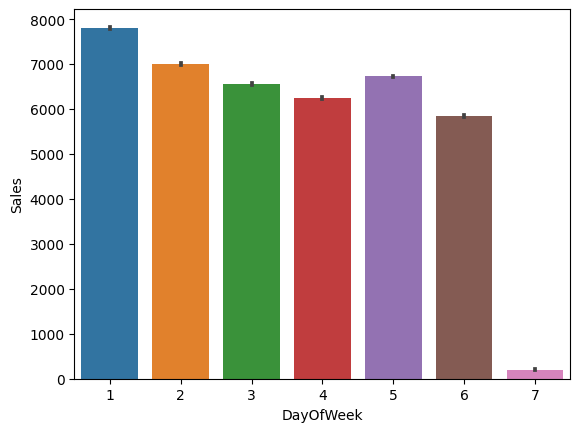

In [24]:
sns.barplot(x='DayOfWeek', y='Sales', data=train)
plt.show()

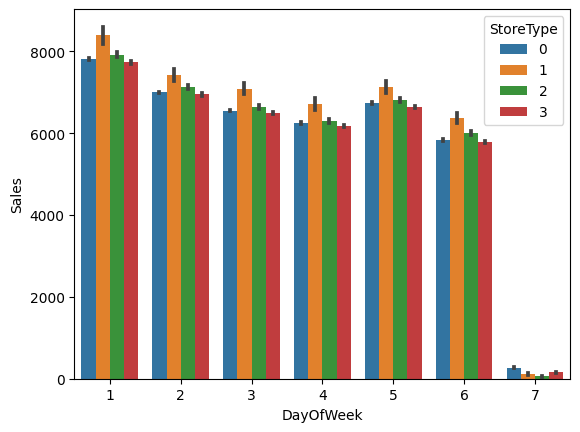

In [25]:
sns.barplot(x='DayOfWeek', y='Sales', hue='StoreType', data=train)
plt.show()

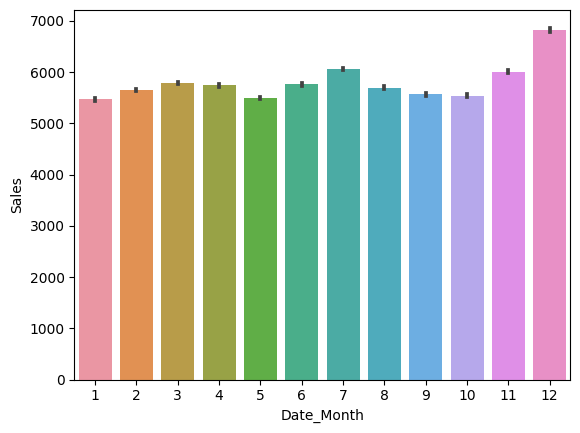

In [17]:
sns.barplot(x='Date_Month', y='Sales', data=train)
plt.show()

-> Die Umsätze sind im Dezember und Juli durschnittlich höher als im Rest des Jahres.

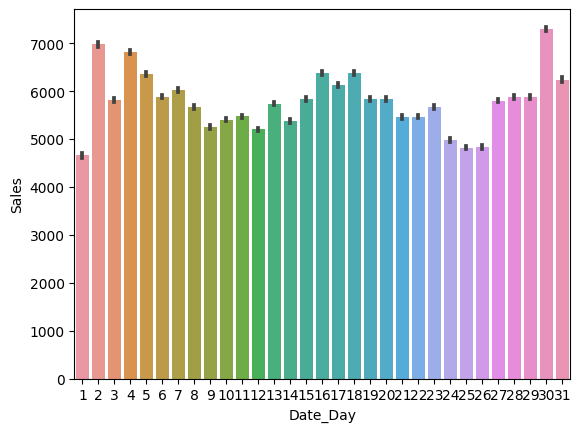

In [19]:
sns.barplot(x='Date_Day', y='Sales', data=train)
plt.show()

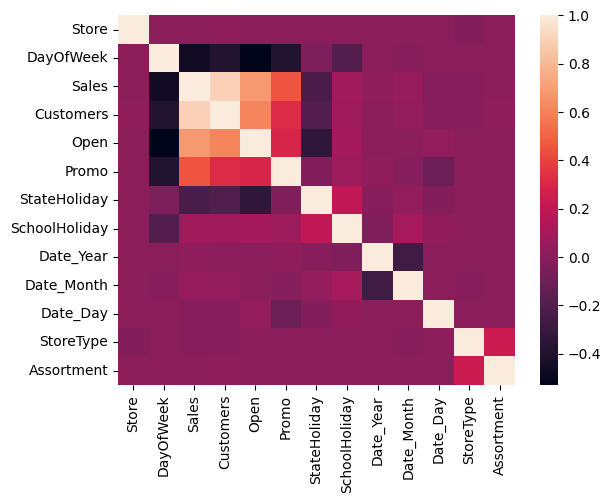

In [21]:
corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()



-> Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday haben eine mäßige, negative Korrelation mit Sales.